# Random forest pipeline
The jupyter notebook for good permeaters prediction using random forest model  
Including hyper-parameter tuning, leave-one-out cross validation, and feature importance extraction  

Auther: Yue (Shawn) Shen  
Date: Jun 08, 2021  

In [1]:
#load pandas and numpy modules
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read raw data
df = pd.read_csv('dataset.csv')

if df.isnull().values.any():
    print ('missing values!')
else:
    print('pass')

df.head()

pass


,MolID,target_permeator,BalabanJ,BertzCT,Chi0,Chi1,Chi0n,Chi1n,Chi2n,Chi3n,...,PMI3,RadiusOfGyration,SpherocityIndex,avg_asphericity,avg_acylindricity,avg_kappa2,avg_rg,avg_largest_principal_rg,avg_middle_principal_rg,avg_smallest_principal_rg
0,1500272,0,1.429,1053.463,24.526,17.092,21.986,13.271,10.508,8.949,...,8960.40,4.71,0.26,0.377154,0.212826,0.287922,0.526401,0.505270,0.457168,0.299362
1,1501007,0,1.868,592.306,16.113,10.436,12.477,7.260,5.618,3.565,...,5322.33,4.43,0.13,0.310194,0.123611,0.349557,0.411174,0.391925,0.369452,0.216417
2,1501150,1,2.143,675.300,17.035,10.863,13.464,7.701,5.718,4.335,...,4454.32,3.82,0.13,0.307322,0.156884,0.302154,0.421545,0.403439,0.370261,0.235260
3,1503243,0,1.847,673.567,17.527,11.469,13.852,8.151,6.130,4.164,...,6455.60,4.67,0.11,0.365638,0.124397,0.441792,0.454138,0.437384,0.416621,0.212002
4,1504185,0,1.467,1753.790,31.949,22.397,27.620,16.150,12.755,10.137,...,9996.12,4.41,0.35,0.289902,0.182358,0.134712,0.493310,0.454962,0.416616,0.325698


## 1. Hyper-parameter tuning

In [2]:
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score,roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, ParameterGrid, cross_val_predict

RF_param_grid = {"n_estimators" : [100, 200, 300],
                "min_samples_leaf" : [1, 2, 4],
                "max_features" : ['sqrt', 'log2']}

def grid_search_loocv(X, y, estimator, sampler, param_grid):
    # search for best hyper-parameter in leave-one-out style
    from operator import itemgetter
    cv = LeaveOneOut()
    param_combinations = ParameterGrid(param_grid)
    result_list = []
    Y_pred = np.array([])
    metric_cols=['F1','precision','recall','accuracy', 'AUROC','confusion_matrix', 'hyper-parameter combination']
    print("---all combinations with score metrics---")
    print('|'.join(metric_cols)) # title row
    
    for param in param_combinations:
        model = Pipeline([('over-sampling', sampler), ('clf', estimator.set_params(**param))])
        # model = Pipeline([('clf', estimator.set_params(**param))])
        pred_probs = cross_val_predict(model, X, y, cv=cv, n_jobs=-1, method='predict_proba')
        Y_pred = pred_probs.argmax(axis=1)

        # claculate metrics
        f1 = round(f1_score(y,Y_pred),3)
        prec = round(precision_score(y,Y_pred),3)
        recall = round(recall_score(y,Y_pred),3)
        acc = round(accuracy_score(y,Y_pred),3)
        AUC = round(roc_auc_score(y, pred_probs[:,1]),3)
        conf = confusion_matrix(y,Y_pred).tolist()

        print((f1, prec, recall, acc, AUC, conf, param))
        result_list.append((f1, prec, recall, acc, AUC, conf, param))

    result_df = pd.DataFrame(result_list, columns=['f1', 'prec', 'recall', 'acc', 'AUC', 'conf', 'param'])
    # top_param = max(result_list,key=itemgetter(3)) # rank by accuracy
    top_param = result_df.sort_values(['acc', 'AUC'],ascending=False).iloc[0]
    print("---------------------")
    print(f"tuned parameteres:{top_param.to_list()}\n") # best parameters combination
    
    return top_param[-1]

In [3]:
descriptors = ['MinAbsEStateIndex','NumAliphaticCarbocycles','avg_asphericity','EState_VSA2','MolLogP','PMI2','NumAromaticRings','avg_acylindricity','MinAbsPartialCharge','FractionCSP3','NPR1','FpDensityMorgan2','TPSA','NumAromaticCarbocycles','HallKierAlpha','NumHAcceptors','avg_smallest_principal_rg','NPR2','NumAliphaticHeterocycles','MinPartialCharge','NumRotatableBonds','Kappa3','NumHDonors','avg_rg','MinEStateIndex','NumHeteroatoms','LabuteASA']

# specify X and Y
Y = df.iloc[:, 1]
X_raw = df.iloc[:, 2:]

if Y.isnull().values.any():
    print("Warning: NaN found")

# standardize X to have mean and std 0 and 1
X = StandardScaler().fit_transform(X_raw[descriptors])
Y = Y.to_numpy()

RF = RandomForestClassifier(random_state=1)
sampler = KMeansSMOTE(kmeans_estimator=KMeans(n_clusters=5, random_state=1), k_neighbors=2, cluster_balance_threshold=0.3, n_jobs=-1, random_state=1)
# sampler = SMOTE()
top_param = grid_search_loocv(X, Y, RF, sampler, RF_param_grid)

---all combinations with score metrics---
F1|precision|recall|accuracy|AUROC|confusion_matrix|hyper-parameter combination
(0.333, 0.348, 0.32, 0.515, 0.485, [[26, 15], [17, 8]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100})
(0.333, 0.348, 0.32, 0.515, 0.488, [[26, 15], [17, 8]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200})
(0.298, 0.318, 0.28, 0.5, 0.492, [[26, 15], [18, 7]], {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300})
(0.392, 0.385, 0.4, 0.53, 0.489, [[25, 16], [15, 10]], {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100})
(0.36, 0.36, 0.36, 0.515, 0.48, [[25, 16], [16, 9]], {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200})
(0.392, 0.385, 0.4, 0.53, 0.494, [[25, 16], [15, 10]], {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300})
(0.4, 0.4, 0.4, 0.545, 0.529, [[26, 15], [15, 10]], {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100})
(0.327,

## 2. Leave-one-out cross validation with tunned hyper-parameter set

---leave one out validation with best parameter set---
      F1  precision  recall  accuracy  AUROC      confusion_matrix
0  0.458      0.478    0.44     0.606   0.53  [[29, 12], [14, 11]]


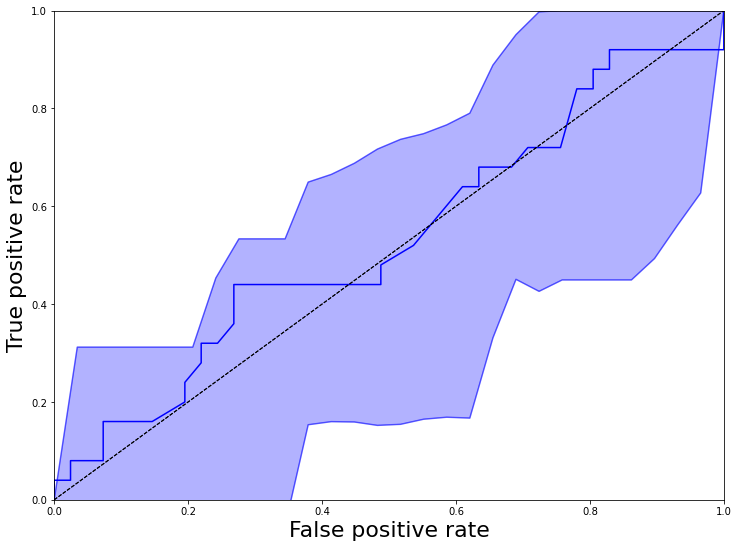

In [4]:
def loocv(X, Y, model, sampler, hyperparam):
    cv = LeaveOneOut()
    print("---leave one out validation with best parameter set---")
    final_model = Pipeline([('over-sampling', sampler), ('clf', model.set_params(**hyperparam))])
    pred_probs = cross_val_predict(final_model, X, Y, cv=cv, n_jobs=-1, method='predict_proba')
    Y_pred = pred_probs.argmax(axis=1)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(Y,pred_probs[:,1])
    plt.figure(figsize=(12,9))
    plt.plot(fpr, tpr, color='b')
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')

    # scoring metrics
    f1 = round(f1_score(Y,Y_pred),3)
    prec = round(precision_score(Y,Y_pred),3)
    recall = round(recall_score(Y,Y_pred),3)
    acc = round(accuracy_score(Y,Y_pred),3)
    AUC = round(roc_auc_score(Y, pred_probs[:,1]),3)
    conM = confusion_matrix(Y,Y_pred).tolist()
    metric_cols=['F1','precision','recall','accuracy','AUROC','confusion_matrix']
    print(pd.DataFrame([[f1,prec,recall,acc,AUC,conM]], columns = metric_cols))

    # confidence interval bands with 5-fold cross validation
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    metric_cols=['F1','precision','recall','accuracy','ROC_AUC','confusion_matrix']
    tprs = []
    fprs = []
    for train_index, val_index in cv.split(X, Y):

        X_train, X_val, Y_train, Y_val = X[train_index], X[val_index], Y[train_index], Y[val_index]

        pred_probs = final_model.fit(X_train, Y_train).predict_proba(X_val)
        Y_pred = pred_probs.argmax(axis=1) # get predicted value from probability of two classes

        fpr, tpr, _ = roc_curve(Y_val,pred_probs[:,1])
        tprs.append(tpr)
        fprs.append(fpr)

    # calculate mean and std from cross validation
    fpr_mean = np.linspace(0, 1, 30)
    interp_tprs = []
    for i in range(5):
        fp = fprs[i]
        tp = tprs[i]
        interp_tpr = np.interp(fpr_mean, fp, tp)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    tpr_mean = np.mean(interp_tprs, axis=0)
    tpr_mean[-1] = 1.0
    tpr_std = 1.96*np.std(interp_tprs, axis=0) # 1.96 stands for 95% CI
    tpr_upper = np.clip(tpr_mean+tpr_std, 0, 1)
    tpr_lower = tpr_mean-tpr_std

    plt.plot(fpr_mean, tpr_upper, color='b', alpha=0.5)
    plt.plot(fpr_mean, tpr_lower, color='b', alpha=0.5)
    plt.fill_between(fpr_mean, tpr_upper, tpr_lower, color='b', alpha=0.3)
    plt.axline([0, 0], [1, 1], linewidth=1, color='k', linestyle='--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel('False positive rate', fontdict={'size':'22'})
    plt.ylabel('True positive rate', fontdict={'size':'22'})

    plt.show()

    return

loocv(X, Y, RF, sampler, top_param)

## 3. Feature importance

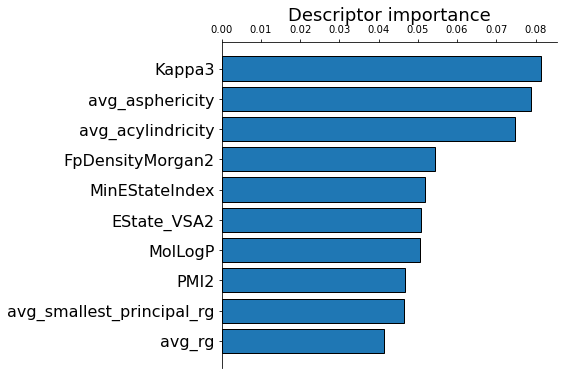

                   descriptor  importance
0                      Kappa3    0.081287
1             avg_asphericity    0.078880
2           avg_acylindricity    0.074661
3            FpDensityMorgan2    0.054393
4              MinEStateIndex    0.051867
5                 EState_VSA2    0.050881
6                     MolLogP    0.050526
7                        PMI2    0.046747
8   avg_smallest_principal_rg    0.046428
9                      avg_rg    0.041258
10          MinAbsEStateIndex    0.037865
11                  LabuteASA    0.037735
12           MinPartialCharge    0.037513
13               FractionCSP3    0.036893
14                       NPR2    0.035104
15          NumRotatableBonds    0.032632
16                       NPR1    0.031907
17              HallKierAlpha    0.028887
18                       TPSA    0.027619
19        MinAbsPartialCharge    0.027357
20             NumHeteroatoms    0.019117
21              NumHAcceptors    0.018574
22   NumAliphaticHeterocycles    0

In [5]:
from matplotlib import pyplot as plt

def get_importance(X, Y, clf, hyperparam, descriptors):
    model = clf.set_params(**hyperparam)
    model.fit(X,Y)
    feature_importance = model.feature_importances_
    # print(descriptors)
    importance_df = pd.DataFrame({'descriptor':descriptors, 'importance':feature_importance})
    importance_df.sort_values(by=['importance'], ascending=False, inplace=True)
    importance_df = importance_df.reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(6,6))
    y_pos = np.arange(10)
    ax.barh(y_pos, importance_df['importance'].iloc[0:10], align='center', edgecolor='k')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importance_df['descriptor'].iloc[0:10], fontsize=16)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.xaxis.tick_top()
    ax.set_xlabel('Descriptor importance', fontsize=18)
    ax.xaxis.set_label_position('top')

    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

    print(importance_df)
    return

get_importance(X, Y, RF, top_param, descriptors)